In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Create a sample dataset
np.random.seed(42)
n_samples = 500

# Simulate battery data
charge_cycles = np.random.randint(50, 1000, n_samples)
avg_temp_c = np.random.normal(25, 5, n_samples) + (charge_cycles / 200)

# Simulate recent high temp events (more indicative of immediate risk)
recent_max_temp = avg_temp_c + np.random.uniform(0, 15, n_samples) * (charge_cycles / 500)
voltage_variation = np.random.uniform(0.01, 0.15, n_samples) * (charge_cycles / 800 + 1) # Higher variation in older batteries
soh_estimate = 100 - (charge_cycles * 0.025) - ((avg_temp_c - 25) * 0.06 * (avg_temp_c > 25)) + np.random.normal(0, 1, n_samples)
soh_estimate = np.clip(soh_estimate, 70, 100)

In [6]:
# Create DataFrame
data = pd.DataFrame({
    'charge_cycles': charge_cycles,
    'recent_max_temp_c': recent_max_temp,
    'voltage_variation': voltage_variation,
    'estimated_soh': soh_estimate
})

In [7]:
data

,charge_cycles,recent_max_temp_c,voltage_variation,estimated_soh
0,152,21.499222,0.104886,96.093938
1,485,30.397997,0.137474,88.802998
2,910,51.400320,0.031606,75.955339
3,320,26.477969,0.207392,92.005852
4,156,29.743302,0.032523,97.596430
...,...,...,...,...
495,916,49.032177,0.024763,75.154857
496,867,50.805674,0.239499,77.295014
497,970,54.116623,0.257125,75.818194
498,457,38.430225,0.164939,88.814313


In [8]:
# Create Binary Target: 'Needs Maintenance'
# Define criteria: e.g., SOH < 80% OR recent high temp > 45 C OR high voltage variation
threshold_soh = 80
threshold_temp = 45
threshold_volt_var = 0.10

data['Needs_Maintenance'] = (
    (data['estimated_soh'] < threshold_soh) |
    (data['recent_max_temp_c'] > threshold_temp) |
    (data['voltage_variation'] > threshold_volt_var)
).astype(int) # Convert boolean to 0 or 1


In [9]:
data

,charge_cycles,recent_max_temp_c,voltage_variation,estimated_soh,Needs_Maintenance
0,152,21.499222,0.104886,96.093938,1
1,485,30.397997,0.137474,88.802998,1
2,910,51.400320,0.031606,75.955339,1
3,320,26.477969,0.207392,92.005852,1
4,156,29.743302,0.032523,97.596430,0
...,...,...,...,...,...
495,916,49.032177,0.024763,75.154857,1
496,867,50.805674,0.239499,77.295014,1
497,970,54.116623,0.257125,75.818194,1
498,457,38.430225,0.164939,88.814313,1


In [10]:
print("--- Simulated Data with Binary Target (First 5 rows) ---")
print(data.head())
print("\nClass distribution:")
print(data['Needs_Maintenance'].value_counts(normalize=True)) # Check for imbalance


--- Simulated Data with Binary Target (First 5 rows) ---
   charge_cycles  recent_max_temp_c  voltage_variation  estimated_soh  \
0            152          21.499222           0.104886      96.093938   
1            485          30.397997           0.137474      88.802998   
2            910          51.400320           0.031606      75.955339   
3            320          26.477969           0.207392      92.005852   
4            156          29.743302           0.032523      97.596430   

   Needs_Maintenance  
0                  1  
1                  1  
2                  1  
3                  1  
4                  0  

Class distribution:
Needs_Maintenance
1    0.696
0    0.304
Name: proportion, dtype: float64


In [11]:
# Prepare Data for Model 
X = data.drop('Needs_Maintenance', axis=1)
y = data['Needs_Maintenance']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y) # Stratify preserves class distribution

In [12]:
# Train a RandomForest Classifier
print("\nTraining RandomForest Classifier...")
# class_weight='balanced' helps handle potential imbalance between classes
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced', max_depth=8, min_samples_leaf=5)
rf_clf.fit(X_train, y_train)


Training RandomForest Classifier...


RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=5,
                       n_jobs=-1, random_state=42)

In [13]:
# Make Predictions and Evaluate
print("\nEvaluating model...")
y_pred = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1] # Probabilities for the positive class (Needs_Maintenance=1)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
# AUC score measures the model's ability to distinguish between classes
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")


Evaluating model...
--- Classification Report ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.99      0.99        87

    accuracy                           0.99       125
   macro avg       0.99      0.99      0.99       125
weighted avg       0.99      0.99      0.99       125

Accuracy: 0.992
AUC Score: 1.000


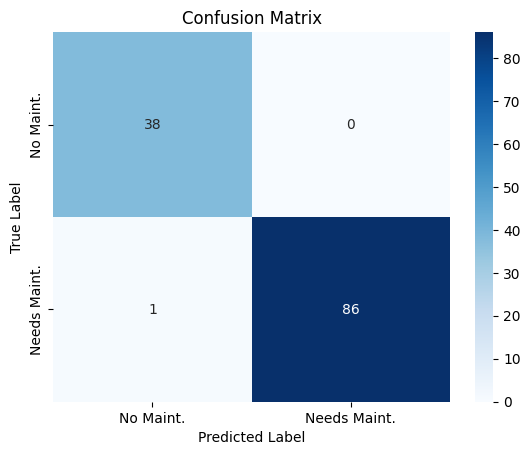

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Maint.', 'Needs Maint.'], yticklabels=['No Maint.', 'Needs Maint.'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
